In [1]:
import sys
import io
import numpy as np
from requests.auth import HTTPBasicAuth

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import timedelta
import math

from folium import plugins
from folium.plugins import HeatMapWithTime
from folium.plugins import MarkerCluster
import folium 

import webbrowser

sys.path.insert(1, '../')
from get_data_API import get_data

In [2]:
from jinja2 import Template 
from folium.map import Layer

class HeatMapWithTimeAdditional(Layer):
    _template = Template("""
        {% macro script(this, kwargs) %}
            var {{this.get_name()}} = new TDHeatmap({{ this.data }},
                {heatmapOptions: {
                    radius: {{this.radius}},
                    minOpacity: {{this.min_opacity}},
                    maxOpacity: {{this.max_opacity}},
                    scaleRadius: {{this.scale_radius}},
                    useLocalExtrema: {{this.use_local_extrema}},
                    defaultWeight: 1,
                    {% if this.gradient %}gradient: {{ this.gradient }}{% endif %}
                }
            }).addTo({{ this._parent.get_name() }});
        {% endmacro %}
    """)

    def __init__(self, data, name=None, radius=15,
                 min_opacity=0, max_opacity=0.6,
                 scale_radius=False, gradient=None, use_local_extrema=False,
                 overlay=True, control=True, show=True):
        super(HeatMapWithTimeAdditional, self).__init__(
            name=name, overlay=overlay, control=control, show=show
        )
        self._name = 'HeatMap'
        self.data = data

        # Heatmap settings.
        self.radius = radius
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity
        self.scale_radius = 'true' if scale_radius else 'false'
        self.use_local_extrema = 'true' if use_local_extrema else 'false'
        self.gradient = gradient

In [3]:
# get data
df = get_data()

200


In [4]:
df

,ID,time,temperature,humidity,light,motion,co2,coordinates
0,a8-17-58-ff-fe-04-65-01,2023-04-02T22:09:29.842Z,23.1,12,2,77,None,"[65.05804068316928, 25.466609521425063]"
1,a8-17-58-ff-fe-03-0f-4b,2023-04-02T22:09:30.287Z,19.9,11,72,0,413,"[65.05862, 25.46645]"
2,a8-17-58-ff-fe-03-0f-cf,2023-04-02T22:09:32.371Z,12.8,22,2,0,557,"[65.05795, 25.46894]"
3,a8-17-58-ff-fe-03-10-41,2023-04-02T22:09:32.729Z,20.0,11,0,0,611,"[65.06116, 25.46892]"
4,a8-17-58-ff-fe-03-10-32,2023-04-02T22:09:38.779Z,21.1,16,2,0,436,"[65.05774, 25.46448]"
...,...,...,...,...,...,...,...,...
26957,a8-17-58-ff-fe-03-10-72,2023-04-03T22:09:01.169Z,19.7,14,8,0,496,"[65.05977, 25.46647]"
26958,a8-17-58-ff-fe-03-0f-da,2023-04-03T22:09:03.733Z,21.9,12,117,1,None,"[65.05884, 25.46757]"
26959,a8-17-58-ff-fe-04-63-38,2023-04-03T22:09:06.617Z,20.1,10,0,87,None,"[65.05967, 25.4634]"
26960,a8-17-58-ff-fe-03-10-5f,2023-04-03T22:09:19.181Z,20.7,36,151,0,437,"[65.05749, 25.46956]"


# Get unique sensor locations

In [5]:
unique_sensor_id_list = df["ID"].unique()
co2_sensors = []
audio_sensors = []

for sensor in unique_sensor_id_list:
    if (df[df["ID"]==sensor]['co2'].tail(1).values[0]) == None:
        audio_sensors.append(df[df["ID"]==sensor].tail(1).values.tolist())
    else:
        co2_sensors.append(df[df["ID"]==sensor].tail(1).values.tolist())

In [6]:
print(len(co2_sensors))
print(len(audio_sensors))


274
57


In [57]:
co2_sensors[0]

[['a8-17-58-ff-fe-03-0f-4b',
  '2023-04-03T21:55:22.578Z',
  20.5,
  11,
  120,
  0,
  429,
  [65.05862, 25.46645]]]


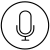
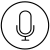
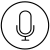
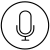
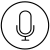
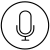
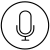
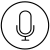
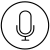
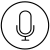
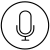
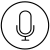
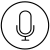
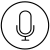
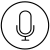
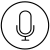
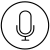
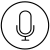
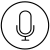
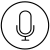
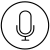
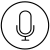
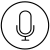
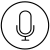
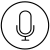
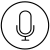
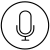
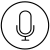
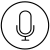
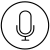
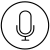
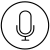
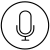
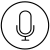
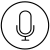
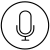
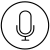
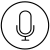
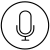
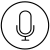
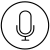
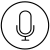
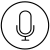
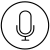
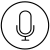
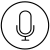
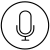
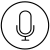
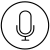
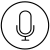
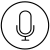
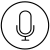
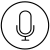
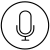
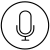
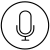
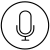
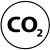
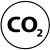
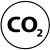
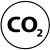
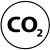
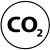
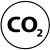
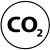
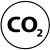
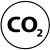
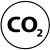
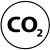
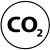
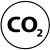
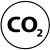
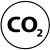
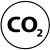
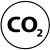
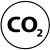
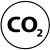
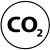
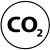
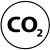
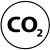
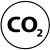
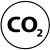
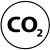
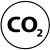
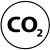
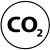
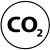
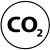
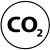
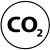
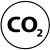
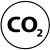
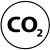
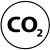
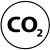
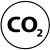
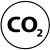
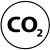
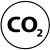
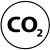
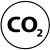
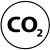
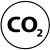
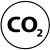
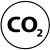
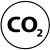
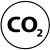
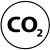
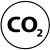
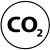
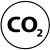
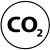
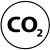
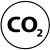
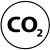
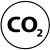
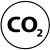
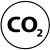
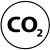
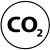
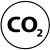
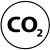
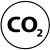
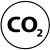
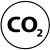
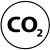
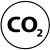
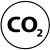
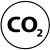
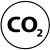
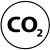
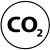
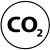
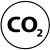
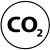
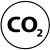
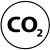
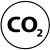
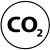
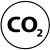
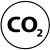
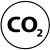
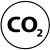
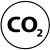
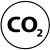
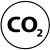
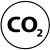
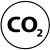
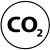
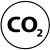
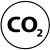
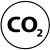
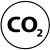
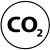
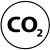
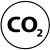
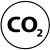
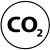
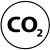
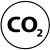
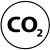
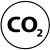
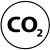
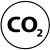
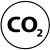
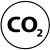
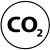
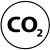
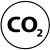
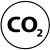
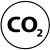
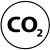
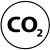
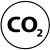
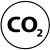
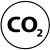
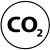
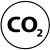
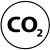
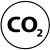
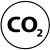
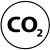
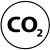
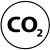
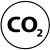
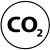
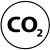
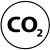
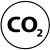
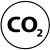
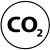
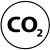
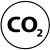
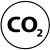
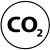
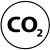
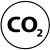
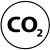
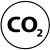
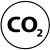
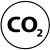
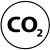
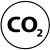
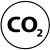
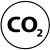
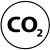
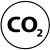
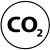
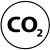
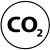
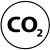
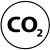
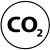
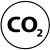
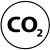
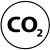
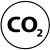
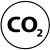
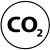
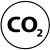
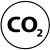
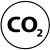
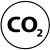
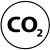
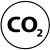
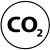
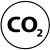
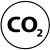
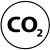
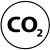
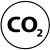
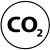
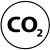
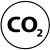
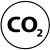
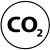
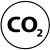
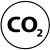
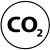
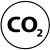
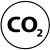
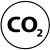
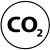
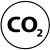
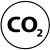
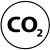
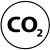
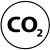
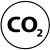
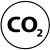
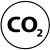
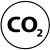
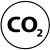
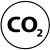
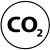
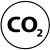
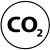
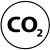
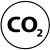
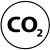
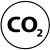
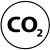
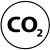
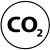
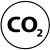
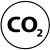
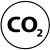
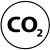
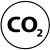
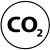
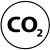
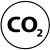
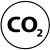
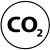
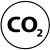
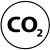
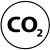
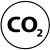
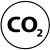
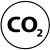
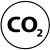
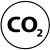
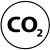
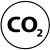
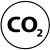
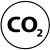
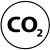
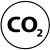
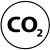
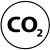
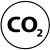
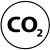
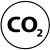
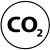
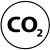
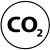
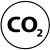
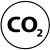
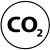
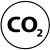
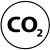
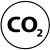
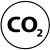
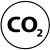
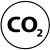
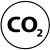
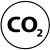
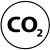
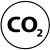
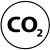
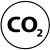
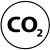
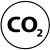
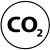
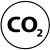
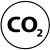
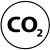
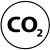
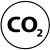
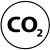
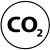
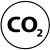
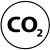
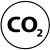
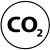
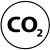
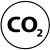
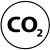
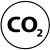
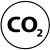

In [68]:
m = folium.Map([65.059228, 25.465375], zoom_start=16.45)

sensors_cluster = folium.FeatureGroup(name="sensors").add_to(m)

for sensor in audio_sensors:
    custom_icon = folium.CustomIcon("sound_icon.png", icon_size=(14, 14))
    
    time = sensor[0][1]
    #2023-04-03T22:09:01.169Z
    form_time = "{}.{}.{} {}:{}".format(time[8:10],time[5:7],time[0:4],time[11:13],time[14:16])
    iframe = folium.IFrame("""
                            Last measurement<br>
                            Time stamp: {}<br>
                            Temperature: {}°C<br>
                            humidity: {}%<br>
                            light: {} <br>
                            motion:  {}
                            """.format(form_time,
                                       sensor[0][2],
                                       sensor[0][3],
                                       sensor[0][4],
                                       sensor[0][5]
                                      ),
                           width=300,
                           height=150
                          )
    
    popup = folium.Popup(iframe, min_width=200, max_width=200)
    marker = folium.Marker(location=sensor[0][7], icon=custom_icon, popup=popup)
    sensors_cluster.add_child(marker)
    
for sensor in co2_sensors:
    custom_icon = folium.CustomIcon("co2_icon.png", icon_size=(14, 14))
    
    time = sensor[0][1]
    #2023-04-03T22:09:01.169Z
    form_time = "{}.{}.{} {}:{}".format(time[8:10],time[5:7],time[0:4],time[11:13],time[14:16])
    iframe = folium.IFrame("""
                            Last measurement<br>
                            Time stamp: {}<br>
                            Temperature: {}°C<br>
                            humidity: {}%<br>
                            light: {} <br>
                            motion:  {} <br>
                            CO2: {}
                            """.format(form_time,
                                       sensor[0][2],
                                       sensor[0][3],
                                       sensor[0][4],
                                       sensor[0][5],
                                       sensor[0][6]
                                      ),
                           width=300,
                           height=150
                          )
    
    popup = folium.Popup(iframe, min_width=200, max_width=200)
    marker = folium.Marker(location=sensor[0][7], icon=custom_icon, popup=popup)
    sensors_cluster.add_child(marker)


folium.LayerControl().add_to(m)
m

# Testing function code row by row

In [ ]:
selected_data = df[["coordinates", "motion", "time"]]
selected_data

In [ ]:
#Convert ISO-8601 time format to pandas DateTime format 

selected_data.time = pd.to_datetime(selected_data.time, format="%Y-%m-%dT%H:%M:%S.%fZ")
selected_data

In [ ]:
new = selected_data.groupby(pd.Grouper(key='time', freq='15Min'),as_index=False).apply(lambda x: x['time'])
selected_data['period'] = new.index.get_level_values(0)
selected_data


In [ ]:
selected_data['period'].iloc[-1]

In [ ]:
#create time indexes for HeatMapWithTime
timeIndexes = []
selected_data['period'].iloc[-1]
#get last period in dataframe
for i in range(selected_data['period'].iloc[-1]):
    
    #Add multiples of 15min to first timestamp based on period value
    timeIndexes.append(selected_data["time"].iloc[1] + i * timedelta(minutes=15))
    
len(timeIndexes)

In [ ]:
#Check amount of data points in each 15 minute segment
df2 = selected_data.pivot_table(index = ['period'], aggfunc ='size')
df2

# Create function for python file

In [ ]:
def data_formating(df, data_shown):
    
    print(f"Formating data for {data_shown} map")
    selected_data = df[["coordinates", data_shown, "time"]]
    
    #Convert ISO-8601 time format to pandas DateTime format 
    selected_data.time = pd.to_datetime(selected_data.time, format="%Y-%m-%dT%H:%M:%S.%fZ")
    
    #Add new column 'period' to dataframe, every row gets group number based on 15min clusters
    new = selected_data.groupby(pd.Grouper(key='time', freq='15Min'),as_index=False).apply(lambda x: x['time'])
    selected_data['period'] = new.index.get_level_values(0)
    
    #create time indexes for HeatMapWithTime ----------------------
    timeIndexes = []
    
    #get last period in dataframe
    for i in range(selected_data['period'].iloc[-1] + 1):

        #Add multiples of 15min to first timestamp based on period value
        timeIndexes.append((selected_data["time"].iloc[1] + i * timedelta(minutes=15)).strftime("%d/%m/%Y, %H:%M:%S")[:-3])

    #iterate through dataframe -------------------------------------
    data = [[] for _ in range(len(timeIndexes))]
    
    for _, row in selected_data.iterrows():
        #Checking for None type
        if not row[data_shown] is None:
            #Check that data isn't zero or NaN
            if (not math.isnan(row[data_shown]) and row[data_shown] != 0.0):
                
                data[row["period"]].append([row['coordinates'][0],row['coordinates'][1],row[data_shown]])
              
    return data, timeIndexes       
 

In [ ]:
#Min-Max scale motion data
column = "motion"
df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

#Create heatmap using motion data
motion_data, motion_time = data_formating(df, "motion")


#Create heatmap using co2 data
co2_data, co2_time = data_formating(df, "co2")

#Create heatmap using temperature data
temperature_data, temperature_time = data_formating(df, "temperature")

#Create heatmap using humidity data
humidity_data, humidity_time = data_formating(df, "humidity")


In [ ]:
m = folium.Map([65.059228, 25.465375], zoom_start=16.45)

#Motion
HeatMapWithTime(motion_data, index=motion_time, auto_play=True, max_opacity=0.5, name="Motion").add_to(m)
#CO2
HeatMapWithTimeAdditional(co2_data, show=False, max_opacity=0.5, name="CO2").add_to(m)
#Temperature
HeatMapWithTimeAdditional(temperature_data, show=False, max_opacity=0.5, name="temperature").add_to(m)
#Humidity
HeatMapWithTimeAdditional(humidity_data, show=False, max_opacity=0.5, name="humidity").add_to(m)


folium.LayerControl().add_to(m)

m

In [ ]:
m.save(outfile="index.html")

In [ ]:
#Display html map
webbrowser.open("index.html")